In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6
print("imports ok")

imports ok


In [ ]:
"""
Python classification
There are 3 types of input features:
    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.
Features:
    Age | Objective Feature | age | int (days)
    
    Height | Objective Feature | height | int (cm) |
    
    Weight | Objective Feature | weight | float (kg) |
    
    Gender | Objective Feature | gender | categorical code | 1: femme 2: homme |
    
    Systolic blood pressure | Examination Feature | ap_hi | int |
    
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal|
    
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    
    Smoking | Subjective Feature | smoke | binary |
    
    Alcohol intake | Subjective Feature | alco | binary |
    
    Physical activity | Subjective Feature | active | binary |
    
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
    """

In [ ]:
"""
Il s'agit de faire de la classification ici.
on veut faire un modèle capable de prédire si la personne aura des pbs cardio-vasculaires

"""

In [3]:
#lecture du CSV de données avec pandas :
csv = pd.read_csv(r"./data/cardio_train.csv", error_bad_lines=False, delimiter=";")
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# la colonne des ages est trop funky, ajout d'une colonne en années pour visualisation :
csv["age_years"] = csv.age.map(lambda x: round(x/365.25, 2))

In [5]:
# IMC ou BMI est une mesure utilisée pour mesurée l'état physique des gens 
# La fonction est déclarée ici pour clarté, 
# mais elle aurait très bien marché en lambda pour aller plus vite
def calcimc(line):
    return round(line["weight"]/ ((line["height"]/100)**2),1)

In [6]:
csv["BMI"] = csv.apply(calcimc, axis=1) #axis=1 applique la fonction à chaque ligne
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,22.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,34.9
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,23.5
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,28.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,23.0


In [7]:
csv.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,53.302869,27.555311
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.754974,6.092596
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.560000,3.500000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.360000,23.900000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.940000,26.400000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.390000,30.200000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.920000,298.700000


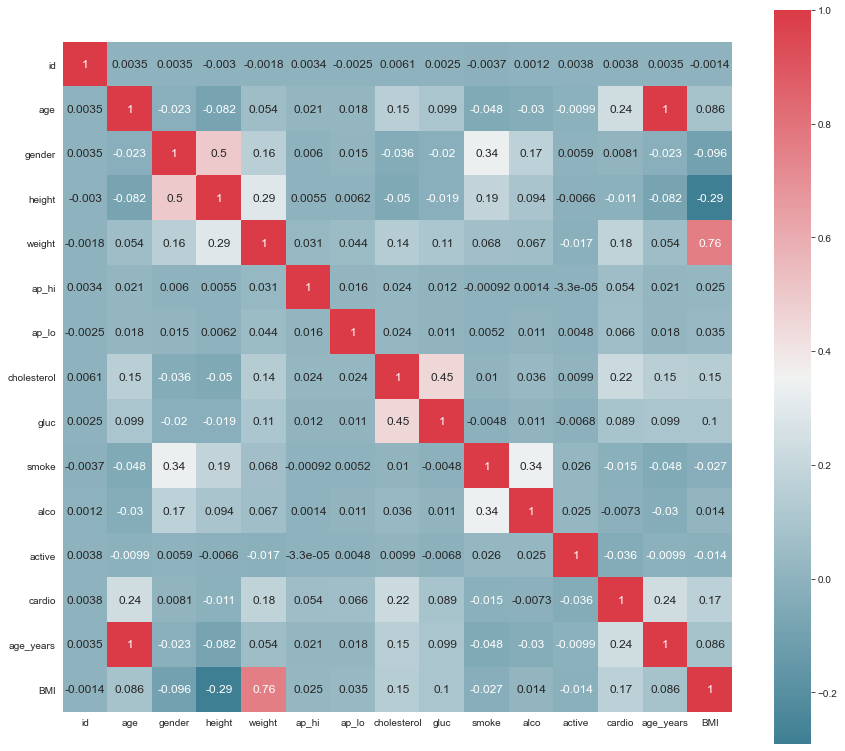

In [13]:
# représentation des corrélations entre les variables en heatmap :

corr = csv.corr()
_ , ax = plt.subplots(figsize =( 15 , 15 ))
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr, 
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax, 
    annot = True, 
    annot_kws = { 'fontsize' : 12 }
)

In [ ]:
# corrélation étrange entre la taille et le genre ?

In [16]:
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,22.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,34.9
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,23.5
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,28.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,23.0


In [20]:
# on ré-écrit la colonne gender avec des 0 et des 1 :
# il semble manquer les infos sur à quoi correspondent les catégories dans le sujet !
csv["b_gender"] = csv.gender.map(lambda x: 1 if x==1 else 0)
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,b_gender
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,22.0,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,34.9,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,23.5,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,28.7,0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,23.0,1


In [32]:
# il faut séparer la variable cholestérol en 3 colonnes binaires :
chol_dummy = pd.get_dummies( csv.cholesterol , prefix='Chol')
print(chol_dummy.head())

# idem pour le glucose :
gluc_dummy = pd.get_dummies( csv.gluc , prefix='gluc')
print("\n",gluc_dummy.head())

   Chol_1  Chol_2  Chol_3
0       1       0       0
1       0       0       1
2       0       0       1
3       1       0       0
4       1       0       0

    gluc_1  gluc_2  gluc_3
0       1       0       0
1       1       0       0
2       1       0       0
3       1       0       0
4       1       0       0


In [26]:
# on vérifie si des données sont manquantes 
csv.isna().any()
# tout semble ok

id             False
age            False
gender         False
height         False
weight         False
ap_hi          False
ap_lo          False
cholesterol    False
gluc           False
smoke          False
alco           False
active         False
cardio         False
age_years      False
BMI            False
b_gender       False
dtype: bool

In [39]:
# assemblage d'une dataframe avec toute les variables pour le training :

# suppression des col inutiles sur la df du csv :
csv_pruned = csv.drop(['id', 'gender','cholesterol', 'gluc',
                       'height', 'weight', 'age', 'cardio'], axis=1)


full_df = pd.concat( [ csv_pruned , chol_dummy , gluc_dummy] , axis=1 )
full_df.head()

,ap_hi,ap_lo,smoke,alco,active,age_years,BMI,b_gender,Chol_1,Chol_2,Chol_3,gluc_1,gluc_2,gluc_3
0,110,80,0,0,1,50.36,22.0,0,1,0,0,1,0,0
1,140,90,0,0,1,55.38,34.9,1,0,0,1,1,0,0
2,130,70,0,0,0,51.63,23.5,1,0,0,1,1,0,0
3,150,100,0,0,1,48.25,28.7,0,1,0,0,1,0,0
4,100,60,0,0,0,47.84,23.0,1,1,0,0,1,0,0


In [44]:
########### CROSS VALIDATION WLL REPLACE THIS ###############
# split du dataset en deux groupes : train et validation :
train_X , valid_X , train_y , valid_y = train_test_split( full_df , csv.cardio ,
                                                         train_size = .7 )

#voir si il faut du test en plus ici
test_X = valid_X.sample(frac = 0.5)
test_Y = valid_y[test_X.index]
valid_X.drop(test_X.index, inplace=True)
valid_y.drop(test_X.index, inplace=True) #this is ok

print (full_df.shape , train_X.shape , valid_X.shape ,
       train_y.shape , valid_y.shape , test_X.shape)

# affichage des longueurs de chaque df :
# print(f"{train_df.shape=}  {val_df.shape=}")

(70000, 14) (49000, 14) (10500, 14) (49000,) (10500,) (10500, 14)


0.9981020408163266


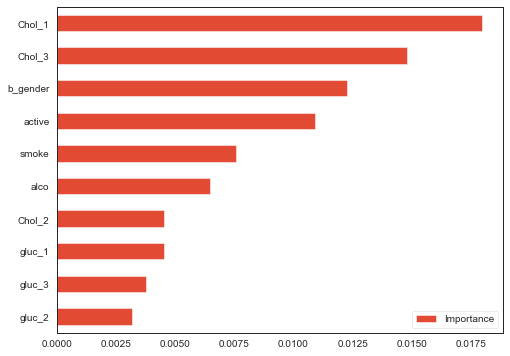

In [47]:
def plot_variable_importance( X , y ):
    classif = RandomForestClassifier( random_state = 99 )
    classif.fit( X , y )
    plot_model_var_imp( classif , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    
plot_variable_importance(train_X, train_y)

In [48]:
# Models models models and models
rand_for = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
sup_vec_mach = SVC()
grad_boost = GradientBoostingClassifier()
k_nearest= KNeighborsClassifier(n_neighbors = 3)
gau_naive= GaussianNB()
logi_reg= LogisticRegression()

In [49]:
rand_for.fit( train_X , train_y )
sup_vec_mach.fit( train_X , train_y )
grad_boost.fit( train_X , train_y )
k_nearest.fit( train_X , train_y )
gau_naive.fit( train_X , train_y )
logi_reg.fit( train_X , train_y )

LogisticRegression()

In [50]:
# exécution un peu lente pour tous les modèles ensemble mais c'est ok :)
print (sup_vec_mach.score( train_X , train_y ) , sup_vec_mach.score( valid_X , valid_y ))
print (rand_for.score( train_X , train_y ) , rand_for.score( valid_X , valid_y ))
print (grad_boost.score( train_X , train_y ) , grad_boost.score( valid_X , valid_y ))
print (k_nearest.score( train_X , train_y ) , k_nearest.score( valid_X , valid_y ))
print (gau_naive.score( train_X , train_y ) , gau_naive.score( valid_X , valid_y ))
print (logi_reg.score( train_X , train_y ) , logi_reg.score( valid_X , valid_y ))

data = [['sup_vec_mach_train', sup_vec_mach.score( train_X , train_y ), 'train', 'Support Vector Machines'] , 
        ['sup_vec_mach_eval',sup_vec_mach.score( valid_X , valid_y ), 'eval', 'Support Vector Machines'],
        ['rand_for_train', rand_for.score( train_X , train_y ), 'train', 'Random forest'] ,
        ['rand_for_eval',rand_for.score( valid_X , valid_y ), 'eval', 'Random forest'],
        ['grad_boost_train',grad_boost.score( train_X , train_y ), 'train', 'Gradient Boosting Classifier'], 
        ['grad_boost_eval',grad_boost.score( valid_X , valid_y), 'eval', 'Gradient Boosting Classifier'],
        ['k_nearest_train', k_nearest.score( train_X , train_y ), 'train', 'K-nearest neighbors'] , 
        ['k_nearest_eval',k_nearest.score( valid_X , valid_y ), 'eval', 'K-nearest neighbors'],
        ['gau_naive_train', gau_naive.score( train_X , train_y ), 'train', 'Gaussian Naive Bayes'] ,
        ['gau_naive_eval', gau_naive.score( valid_X , valid_y ), 'eval', 'Gaussian Naive Bayes'],
        ['logi_reg_train', logi_reg.score( train_X , train_y ), 'train', 'Logistic Regression'],
        ['logi_reg_eval',logi_reg.score( valid_X , valid_y ), 'eval', 'Logistic Regression']]

df = pd.DataFrame(data, columns = ['Name', 'Score', 'Dataset type', 'Model type']) 
df.head()

0.7193469387755103 0.7208571428571429
0.8647551020408163 0.7258095238095238
0.7405510204081632 0.7323809523809524
0.8195918367346938 0.681047619047619
0.5989183673469388 0.5939047619047619
0.6987959183673469 0.7032380952380952


<bound method NDFrame.head of                   Name     Score Dataset type                    Model type
0   sup_vec_mach_train  0.719347        train       Support Vector Machines
1    sup_vec_mach_eval  0.720857         eval       Support Vector Machines
2       rand_for_train  0.864755        train                 Random forest
3        rand_for_eval  0.725810         eval                 Random forest
4     grad_boost_train  0.740551        train  Gradient Boosting Classifier
5      grad_boost_eval  0.732381         eval  Gradient Boosting Classifier
6      k_nearest_train  0.819592        train           K-nearest neighbors
7       k_nearest_eval  0.681048         eval           K-nearest neighbors
8      gau_naive_train  0.598918        train          Gaussian Naive Bayes
9       gau_naive_eval  0.593905         eval          Gaussian Naive Bayes
10      logi_reg_train  0.698796        train           Logistic Regression
11       logi_reg_eval  0.703238         eval           Lo

Text(0.5, 1.0, 'Prediction accuracy by model & dataset type (more is better)')

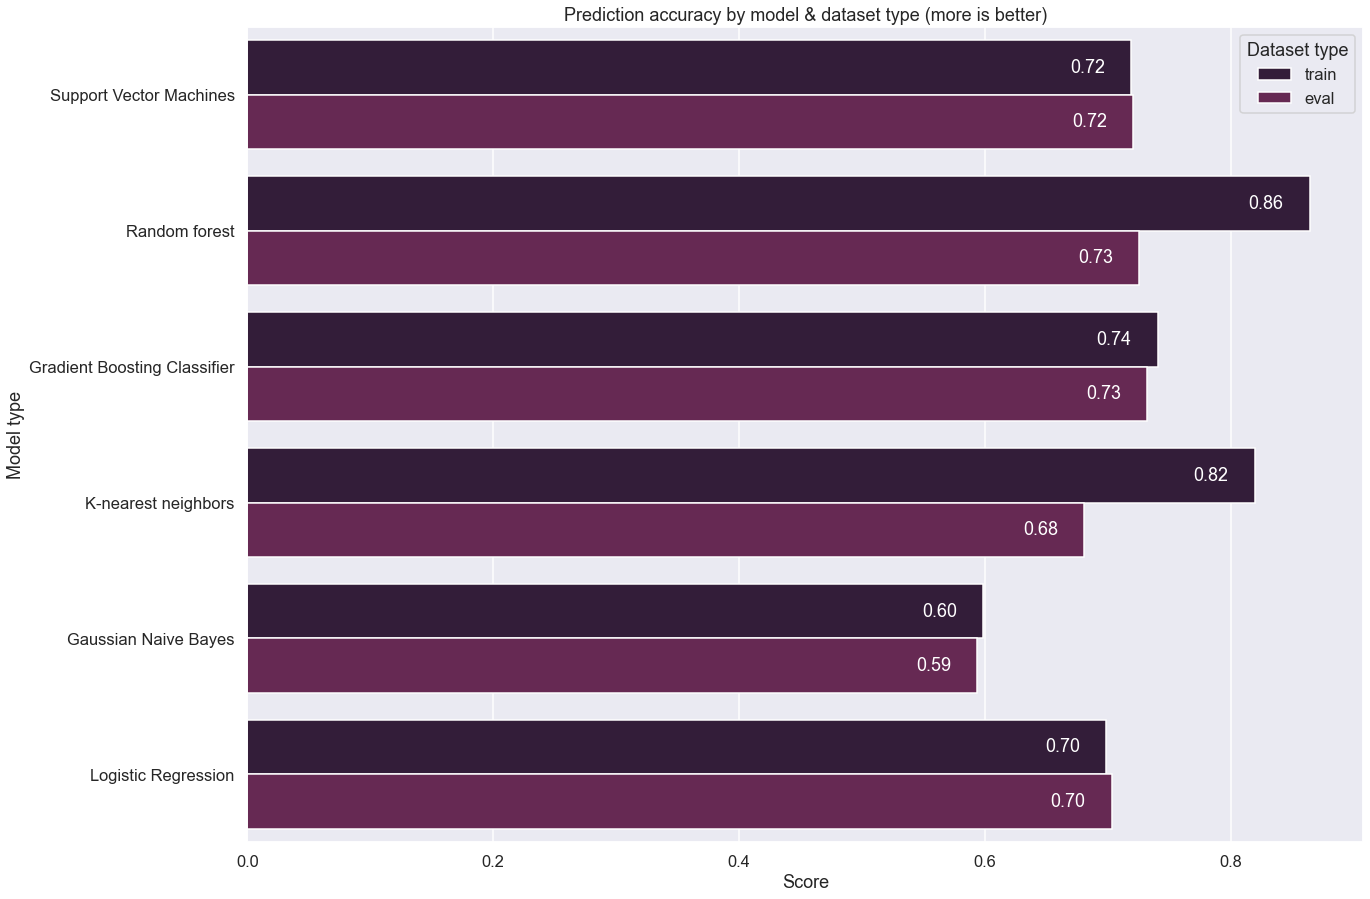

In [64]:
#pretty barplot visualisation
sns.set_context("talk")
# sns.set(rc={'figure.figsize':(20,15)})
pal =sns.color_palette("rocket")
bar = sns.barplot(data = df
            ,x = 'Score'
            ,y = 'Model type'
            ,hue = 'Dataset type'
            ,ci = None
            ,orient = 'h'
            ,palette = pal
            )
# # for legend text 
# plt.setp(bar.get_legend().get_texts(), fontsize='20') 

# plt.setp(bar.get_legend().get_title(), fontsize='30')   


# bar.
for p in bar.patches:
    width = p.get_width()    # get bar length
    bar.text(width-0.05,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center',# vertical alignment
            color = 'white')  

bar.set_title("Prediction accuracy by model & dataset type (more is better)")